## The following securities are included in the Markowitz Portfolio Optimization:
#### XLK, XLF, XLV, XLY, XLP, XLE, XLU, XLI, VNQ

In [2]:
import os
import pickle
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import math
etfs = ['XLK','XLF', 'XLV', 'XLY', 'XLP', 'XLE', 'XLU', 'XLI', 'VNQ']

## Collect security data from yfinance for a period of **10 Years**
##### *this is only done if data is not already pickled*
> You may refresh the data by deleting the security_data.pkl file

In [3]:
security_data = None
if 'security_data.pkl' not in os.listdir():
    security_data = {etf: yf.Ticker(etf).history(period='max') for etf in etfs}
    pickle.dump(security_data, open('security_data.pkl', 'wb+'))
else:
    security_data = pickle.load(open('security_data.pkl', 'rb'))
for etf in security_data:
    security_data[etf] = security_data[etf].tail(4000)

## Format a dataframe for returns of portfolio holdings

In [4]:
temp_returns_dict = {etf: pd.DataFrame(security_data[etf]['Close']) for etf in security_data}
for etf in temp_returns_dict:
    temp_returns_dict[etf] = temp_returns_dict[etf] / temp_returns_dict[etf].shift(1) - 1
    temp_returns_dict[etf] = temp_returns_dict[etf].bfill()
    temp_returns_dict[etf].columns = [etf]

return_df = pd.concat(list(temp_returns_dict.values()), axis=1)
return_df

,XLK,XLF,XLV,XLY,XLP,XLE,XLU,XLI,VNQ
Date,,,,,,,,,
2009-01-16 00:00:00-05:00,-0.040830,-0.165289,-0.024175,-0.058709,-0.011765,-0.053288,-0.017301,-0.046288,-0.111929
2009-01-20 00:00:00-05:00,-0.040830,-0.165289,-0.024175,-0.058709,-0.011765,-0.053288,-0.017301,-0.046288,-0.111929
2009-01-21 00:00:00-05:00,0.048151,0.147277,0.021235,0.030413,0.004851,0.067181,0.011268,0.025469,0.104627
2009-01-22 00:00:00-05:00,-0.022637,-0.061489,0.004236,-0.012506,-0.000878,-0.027435,-0.000348,-0.003280,-0.054704
2009-01-23 00:00:00-05:00,0.014305,0.033333,0.000000,-0.003040,-0.009662,0.029084,0.002090,-0.030089,0.030423
...,...,...,...,...,...,...,...,...,...
2024-12-02 00:00:00-05:00,0.009498,-0.009934,-0.001764,0.008727,-0.001202,-0.010573,-0.021464,-0.007362,-0.014568
2024-12-03 00:00:00-05:00,0.003602,-0.007476,-0.002243,-0.000758,-0.005173,-0.000106,-0.008626,-0.006297,-0.005066
2024-12-04 00:00:00-05:00,0.018285,-0.003766,-0.000545,0.009283,-0.002782,-0.024124,-0.000124,0.004365,-0.002702


In [42]:
import seaborn as sns
np.cov(np.asmatrix(return_df), rowvar=False)

ModuleNotFoundError: No module named 'seaborn'

# Plot Returns

Text(0.5, 1.0, 'Return Distribution of 9 Broad Sector ETFs past 14 years')

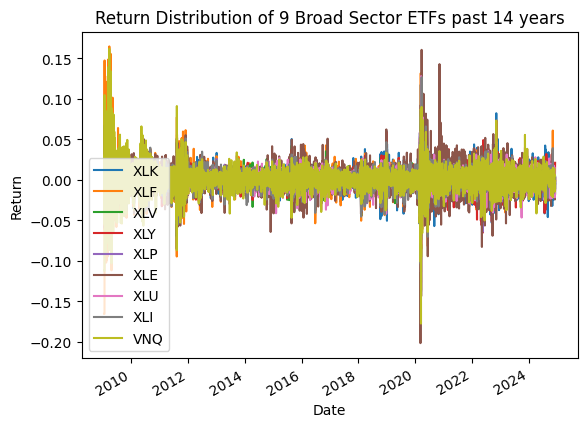

In [5]:
colors=plt.cm.plasma(np.linspace(0,3,20))
ax = return_df.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Return')
ax.set_title('Return Distribution of 9 Broad Sector ETFs past 14 years')

# Cummulative Returns

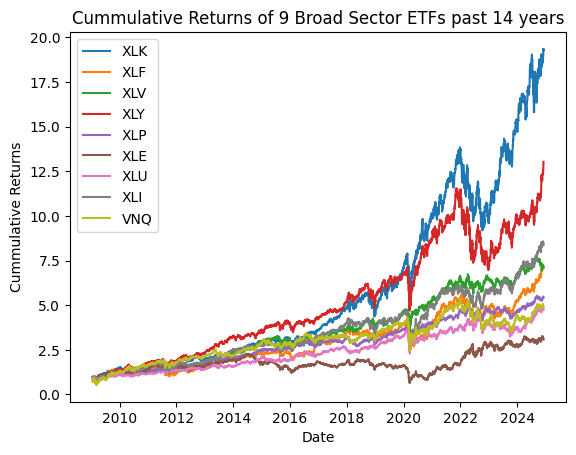

In [6]:
for etf in return_df:
    plt.plot((return_df[etf]+1).cumprod(), label=etf)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Cummulative Returns')
plt.title('Cummulative Returns of 9 Broad Sector ETFs past 14 years')
plt.show()

# Randomly Generate Portfolio's and Plot
## This should result in a parabolic graph, a border will be added later to signify the effeciency frontier

In [21]:
def generate_random_weight_vector(n): # generate a column (n x 1) vector of weights
    w = np.asmatrix(np.random.rand(n)).T
    return w / w.sum() # ensure this is a stochastic vector, i.e. elements sum to 1

In [22]:
cov = np.matrix(return_df.cov()) # create the covariance matrix for returns of all holdings
R = np.matrix(return_df.mean()).T # create the expected returns matrix for all holdings 

def eval_random_portfolio(): # evaluate the expected return & volatility
    w = generate_random_weight_vector(return_df.shape[1]) # random weight vector (n x 1 matrix)
    mu = R.T * w # expected returns = rT * w
    sigma = np.sqrt(w.T * cov * w) # volatility = stddev = sqrt(var) = sqrt(wT * cov * w)
    return mu.item(0), sigma.item(0)

In [23]:
mus = []
sigmas = []

for i in range(int(5e6)): # create 5e6 (5 million) random portfolio weights 
    mu, sigma = eval_random_portfolio() # evaluate
    mus.append(mu) # populate appropriate lists with their corresponding values
    sigmas.append(sigma)


Text(0.5, 1.0, 'Randomly Generated Portfolios Expected Volatility on Return')

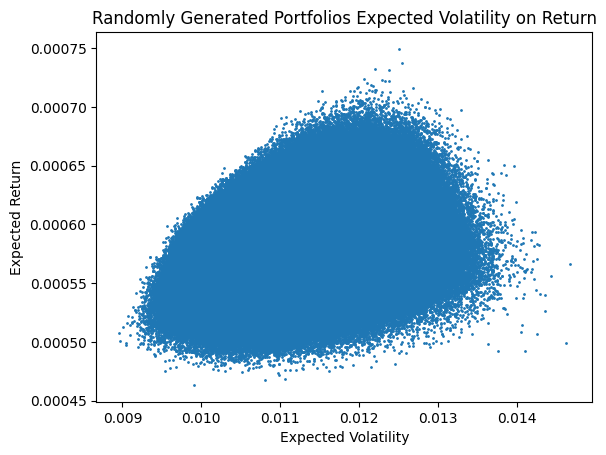

In [24]:
plt.plot(sigmas, mus, 'o', markersize=1) # plot volatility as x axis, return as y-axis
plt.xlabel('Expected Volatility') # set horizontal label
plt.ylabel('Expected Return') # set vertical label
plt.title('Randomly Generated Portfolios Expected Volatility on Return') # set title

# Create effeciency frontier by maximizing returns at a given level of risk

In [27]:
cov = np.matrix(return_df.cov()) # Covariance matrix of all ETFs included in this study (np matrix format)

def weight_list_as_matrix(w_list):
    return np.asmatrix(w_list).T

def expected_portfolio_return(w_list): # Calculates expected portfolio return
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    mu = np.asmatrix(return_df.mean()).T # this is a column vector of mean returns
    return mu.T * w

def negated_expected_portfolio_return(w_list): # Negate what you are trying to minimize to maximize 
    return -1 * expected_portfolio_return(w_list)

def expected_portfolio_volatility(w_list): # Calculate expected volatility of portfolio
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    return (w.T * cov * w).item(0) # vol = wT * cov * w

def weights_constraint(w_list): # ensure weights sum to 1
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    return (np.asmatrix(np.ones(w.shape[0])) * w).item(0) - 1

def variance_constraint(w_list, gamma): # ensure variance is under a threshold of gamma^2
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    return gamma ** 2 - (w.T * cov * w).item(0)  # gamma - cov must be non-negative, i.e., gamme > cov


def get_frontier(): # gets frontier points
    x0 = [1/len(return_df) for etf in return_df] # initial point is equal weighted vector
    bounds = [(0,1) for etf in return_df] # ensure non-negative weights
    options = {
        'maxiter': 100, # max iterations, decrease for faster computation
        'ftol': 1e-10 # tolerance between iteration is 1e-10
    }
    
    frontier_data = [] # stores frontier data in tuple format
    for gamma in np.arange(0.0085, 0.014, 0.0001): # iterate from 0.0085 to 0.014 (bounds of Monte Carlo graph)
        constraints = [{'type': 'eq', 'fun': weights_constraint}, {'type': 'ineq', 'fun': variance_constraint, 'args': (gamma,)}]
        optimal_weights = scipy.optimize.minimize(negated_expected_portfolio_return, x0, bounds=bounds, constraints=constraints, options=options)
        if optimal_weights['success'] == True: # if an solution is found then we use it, else we use the last best weight
            frontier_data.append( (-optimal_weights['fun'], optimal_weights['x']) ) # tuple of expected returns and optimal weights
    return frontier_data

In [28]:
data = get_frontier()

In [29]:
e_r = [_[0] for _ in data] # expected returns across frontier
e_v = [math.sqrt(expected_portfolio_volatility(_[1])) for _ in data] # expected volatility across frontier

C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


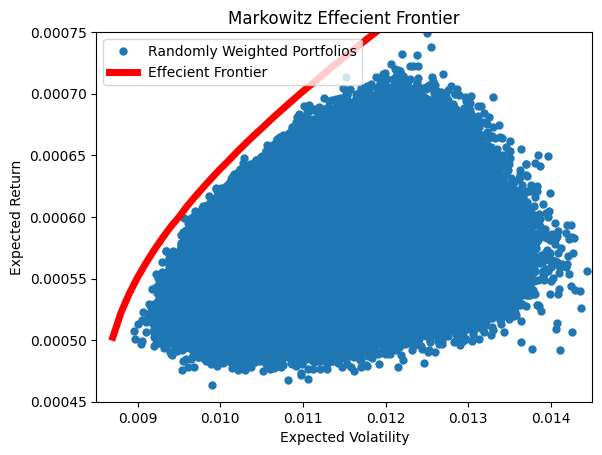

In [30]:
plt.plot(sigmas, mus, 'o', markersize=5, label='Randomly Weighted Portfolios') # plot monte carlo sim
plt.xlabel('Expected Volatility') # set horizontal label
plt.ylabel('Expected Return') # set vertical label 

plt.plot(e_v, e_r, linewidth=5, color='red', label='Effecient Frontier') # plot effecient frontier
plt.xlim(0.009-0.0005,0.014+0.0005) # set graph plot limit horizontally
plt.ylim(0.0005-0.00005, 0.0007+0.00005) # set graph plot limit vertically
plt.title('Markowitz Effecient Frontier') # set title
plt.legend() # show legend

In [34]:
backtest_month_df = None
def backtest_expected_portfolio_return(w_list, monthly_return_df): 
    cov = np.matrix(monthly_return_df.cov()) # cov: Covariance matrix of all ETFs included in this study (np matrix format)
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    mu = np.asmatrix(monthly_return_df.mean()).T # this is a column vector of mean returns
    return mu.T * w

def negated_backtest_expected_portfolio_return(w_list, monthly_return_df):
    return -1 * backtest_expected_portfolio_return(w_list, monthly_return_df)

def backtest_expected_portfolio_volatility(w_list, monthly_return_df): 
    cov = np.matrix(monthly_return_df.cov()) # cov: Covariance matrix of all ETFs included in this study (np matrix format)
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    return (w.T * cov * w).item(0)

def backtest_variance_constraint(w_list, gamma, monthly_return_df): # cov: Covariance matrix of all ETFs included in this study (np matrix format)
    w = weight_list_as_matrix(w_list) # w is a column vector of weights (np matrix format)
    cov = np.matrix(monthly_return_df.cov())
    return gamma ** 2 - (w.T * cov * w).item(0)  # gamma - cov must be non-negative, i.e., gamme > cov

In [35]:
def rebalance_monthly_returns(gamma): # of a 5-year basis (252 trading days/year)
    months_ago = 5 * 12 # start backtest 5 years ago
    w = np.asmatrix([1/len(return_df.columns) for _ in range(len(return_df.columns))]).T # set default weights
    rdfl = len(return_df) # return_df_length, this is used to properly initialize rebalanced_returns
    rebalanced_returns = pd.DataFrame({'Date': return_df.iloc[rdfl - 60 * 21:].index, 'Return': [None for i in range(len(return_df.iloc[rdfl - 60 * 21:]))]})
    rebalanced_returns = rebalanced_returns.set_index('Date')
    weights_history = [] # gonna be a history of weights!
    
    while months_ago >= 0:
        weights_history.append(w)
        month_returns = return_df.iloc[rdfl - months_ago * 21 : rdfl - (months_ago - 1) * 21]  # get the specified month's returns (21 trading days/month)
        
        returns_temp = [] # used to temporarily store weighted returns
        for row in month_returns.iloc: # iterate through the month's rows (i.e., returns)
            R = np.asmatrix(row).T # column matrix of a certain day's returns
            returns_temp.append((w.T * R).item(0)) # weighted returns = wT * R
    
        for i, date in enumerate(month_returns.index):
            rebalanced_returns.loc[date, 'Return'] = returns_temp[i]
        months_ago -= 1
        monthly_cov = month_returns.cov()
        x0 = [1/len(return_df.columns) for i in range(len(return_df.columns))]
        bounds = [(0,1) for etf in return_df]
        options = {
            'maxiter': 100,
            'ftol': 1e-5
        }
        #print(month_returns.cov())
        constraints = [{'type': 'eq', 'fun': weights_constraint}, {'type': 'ineq', 'fun': backtest_variance_constraint, 'args': (gamma, month_returns)}]
        optimal_weights = scipy.optimize.minimize(negated_backtest_expected_portfolio_return, x0, bounds=bounds, args=month_returns, constraints=constraints, options=options)
        if optimal_weights['success'] == True:
            w = np.asmatrix(optimal_weights['x']).T
        else:
            w = np.asmatrix([1/len(return_df.columns) for _ in range(len(return_df.columns))]).T # set default weights
        
    return rebalanced_returns.sort_index(ascending=True), weights_history

# Print return of rebalanced portfolio returns

In [36]:
tdf, weights_history = rebalance_monthly_returns(0.0095)
print((tdf['Return']+1).cumprod()[-1])

1.954572689631033


C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\numpy\lib\_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\pandas\core\frame.py:11211: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\Edwar\.virtualenvs\CS-4111-Project1\MATH 2015 Capstone Project\Lib\site-packages\numpy\lib\_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  

# Print out how portfolio weights change over time
## **NOTE THIS GRAPH'S X-AXIS IS MONTHS AGO**

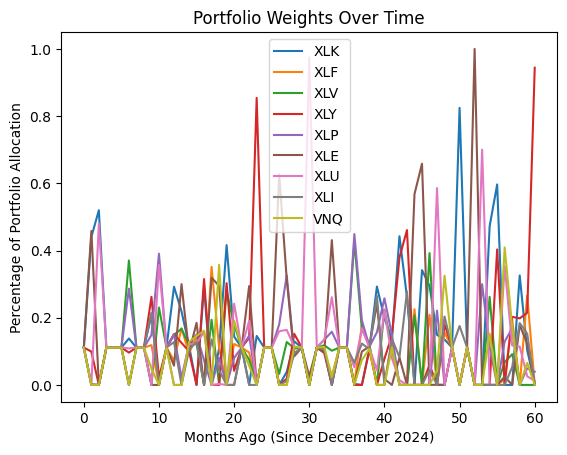

In [37]:
colors = ['r','g','b','yellow','orange','gray','pink','cyan','black']
weight = []
for i in range(len(weights_history[0])):
    weight = []
    for w in weights_history:
        weight.append(w[i].item(0))

    plt.plot(range(len(weight)), weight, label=etfs[i])
plt.legend()
plt.ylabel('Percentage of Portfolio Allocation')
plt.xlabel('Months Ago (Since December 2024)')
plt.title("Portfolio Weights Over Time")
plt.show()

In [18]:
def equal_weights_portfolio_returns():
    months_ago = 5 * 12 # 5 years ago
    rdfl = len(return_df) # makes it easier to calculate/code
    timeframed_returns = pd.DataFrame({'Date': return_df.iloc[rdfl - 60 * 21:].index, 'Return': [None for i in range(len(return_df.iloc[rdfl - 60 * 21:]))]})
    timeframed_returns = timeframed_returns.set_index('Date') # timeframe is 5 years back
    weights = np.asmatrix([1/len(return_df.columns) for _ in range(len(return_df.columns))]).T # column vector of equal weights across all holdings

    
    for date in timeframed_returns.index:
        Rd = np.asmatrix(return_df.loc[date]).T # column vector of a day's returns 
        portfolio_returns = (weights.T * Rd).item(0)
        timeframed_returns.loc[date] = portfolio_returns

    return timeframed_returns

    
    

In [19]:
equal_weight_returns = equal_weights_portfolio_returns()

# Show cummulative returns

Text(0.5, 1.0, 'Rebalancing vs Equal Weighted Portfolio')

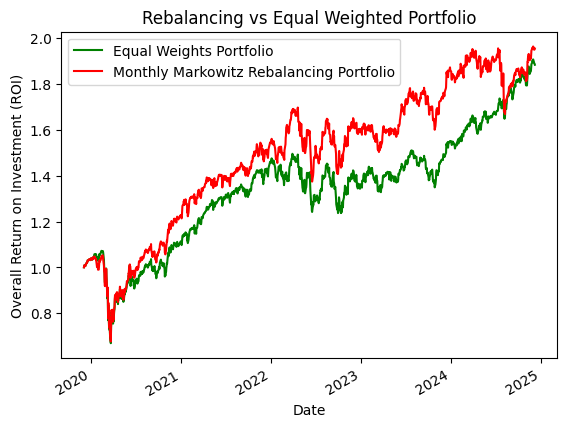

In [20]:
ax = (equal_weight_returns['Return'] + 1).cumprod().plot(label='Equal Weights Portfolio', color='green')
(tdf['Return']+1).cumprod().plot(label='Monthly Markowitz Rebalancing Portfolio', color='red', ax=ax)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Overall Return on Investment (ROI)')
ax.set_title('Rebalancing vs Equal Weighted Portfolio')